# Load DeepFly3D Data

In [9]:
%load_ext autoreload
%autoreload 2
from load import *
import torch
import yaml
import logging
from imp import reload
import matplotlib.pyplot as plt
from liftpose.vision_3d import world_to_camera_dict, reprojection_error
reload(logging)
logger = logging.getLogger(__name__).setLevel(logging.INFO)
from tqdm import tqdm
tqdm.get_lock().locks = []

# decleare data parameters
par_train = {  'data_dir'       : '/data/LiftPose3D/fly_tether/data_DF3D/', # change the path 
               'out_dir'        : '/data/LiftPose3D/fly_tether/cams_test/',
               'train_subjects' : [1],
               'test_subjects'  : [6],
               'actions'        : ['all'],
               'cam_id'         : [0,1,2,4,5,6]}

# merge with training parameters
par_data = yaml.full_load(open('param.yaml', "rb"))
par = {**par_data["data"], **par_train}

# Load 2D data
train_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_2d = load_2D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

# Load 3D data
train_3d, train_keypts, rcams_train = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["train_subjects"],
    actions=par["actions"],
)
test_3d, test_keypts, rcams_test = load_3D(
    par["data_dir"],
    par,
    cam_id=par["cam_id"],
    subjects=par["test_subjects"],
    actions=par["actions"],
)

train_3d = world_to_camera_dict(train_3d, rcams_train)
test_3d = world_to_camera_dict(test_3d, rcams_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train LiftPose3D Network on DeepFly3D Data

In [ ]:
from liftpose.main import train as lp3d_train
from liftpose.lifter.augmentation import add_noise

lp3d_train(train_2d=train_2d, test_2d=test_2d,
           train_3d=train_3d, test_3d=test_3d, 
           train_keypts=train_keypts,
           test_keypts=test_keypts,
           roots=par['roots'],
           target_sets=par['target_sets'],
           out_dir=par['out_dir'],
           training_kwargs={"epochs":100},
          )#augmentation=[add_noise(noise_amplitude=.1)])

/home/gosztolai/Dropbox/github/LiftPose3D/liftpose/preprocess.py:148: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(cp_d, axis=0)
/home/gosztolai/anaconda3/envs/LiftPose3D/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[main.py:250]:INFO:Saving pre-processed 2D data at /data/LiftPose3D/fly_tether/cams_test/stat_2d.pth.tar.
[main.py:269]:INFO:Saving pre-processed 3D data at /data/LiftPose3D/fly_tether/cams_test/stat_3d.pth.tar.
[main.py:297]:INFO:Starting training model.
[main.py:307]:DEBUG:
==================Options=================
[main.py:308]:DEBUG:{   'batch_size': 64,
    'data_dir': '/data/LiftPose3D/fly_tether/cams_test',
    'dropout': 0.5,
    'epochs': 100,
    'exp': '',
    'is_train': True,
    'job': 8,
    'linear_size': 1024,
    'load': None,
    'lr': 0.001,
    'lr_decay': 5000,
    'lr_gamma': 0.9,
    'max_norm': True,
    'noise': None,
    'num_stage': 2,
    'out': '/data/LiftPose3D/fly_tether/cams_test',
    'out_dir': '/data/LiftPose3D/fly_tether/cams_test',
    'predict': False,
    'procrustes': False,
    'resume': False,
    'test': False}
[main.py:309]:DEBUG:==========================================

[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:t

Epoch 000 | LR  0.00090 | Loss Test  0.00000 | Loss Train  0.25297|: 100%|██████████| 9871/9871 [00:53<00:00, 183.47it/s]
Epoch 001 | LR  0.00073 | Loss Test  0.08801 | Loss Train  0.16374|: 100%|██████████| 9871/9871 [00:53<00:00, 185.26it/s]
Epoch 002 | LR  0.00059 | Loss Test  0.07726 | Loss Train  0.15249|: 100%|██████████| 9871/9871 [00:52<00:00, 186.36it/s]
Epoch 003 | LR  0.00048 | Loss Test  0.07398 | Loss Train  0.14597|: 100%|██████████| 9871/9871 [00:53<00:00, 184.00it/s]
Epoch 004 | LR  0.00039 | Loss Test  0.07123 | Loss Train  0.14160|: 100%|██████████| 9871/9871 [00:52<00:00, 188.11it/s]
Epoch 005 | LR  0.00031 | Loss Test  0.07004 | Loss Train  0.13856|: 100%|██████████| 9871/9871 [00:52<00:00, 187.26it/s]
Epoch 006 | LR  0.00025 | Loss Test  0.06820 | Loss Train  0.13624|: 100%|██████████| 9871/9871 [00:52<00:00, 188.31it/s]
Epoch 007 | LR  0.00021 | Loss Test  0.06614 | Loss Train  0.13440|: 100%|██████████| 9871/9871 [00:53<00:00, 186.11it/s]
Epoch 008 | LR  0.00017 

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


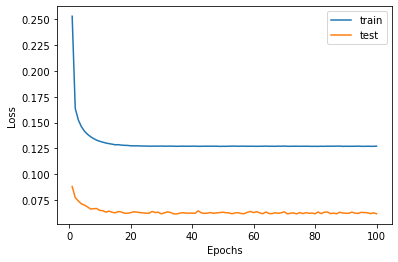

In [4]:
%matplotlib inline
from liftpose.plot import read_log_train, plot_log_train
epoch, lr, loss_train, loss_test, err_test = read_log_train(par['out_dir'])
plot_log_train(plt.gca(), loss_train, loss_test, epoch)

# Run Trained LiftPose3D Network on the Test Data

In [5]:
from liftpose.main import test as lp3d_test
lp3d_test(par['out_dir'])

[main.py:397]:INFO:starting testing in path: /data/LiftPose3D/fly_tether/cams_test/
[lift.py:31]:INFO:Training on the device: cuda:0
[lift.py:53]:INFO:total params: 4.27M
[lift.py:61]:INFO:loading ckpt from '/data/LiftPose3D/fly_tether/cams_test/ckpt_best.pth.tar'
[lift.py:69]:INFO:ckpt loaded (epoch: 63 | err: 0.04522848333992943)
[lift.py:103]:INFO:Saving results: /data/LiftPose3D/fly_tether/cams_test/test_results.pth.tar


# Visualize Predictions

In [6]:
from liftpose.postprocess import load_test_results
data = torch.load(os.path.join(par['out_dir'], "test_results.pth.tar"))
stat_2d, stat_3d = (
    torch.load(os.path.join(par['out_dir'], "stat_2d.pth.tar")),
    torch.load(os.path.join(par['out_dir'], "stat_3d.pth.tar")),
)
test_3d_gt, test_3d_pred, good_keypts = load_test_results(data, stat_2d, stat_3d)

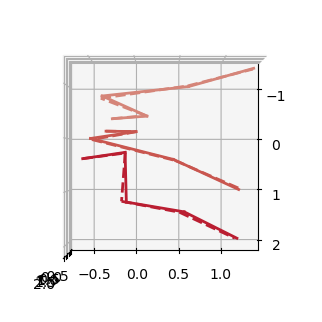

In [7]:
# https://stackoverflow.com/a/38865534/7554774
# conda install ipympl
#%matplotlib widget
%matplotlib inline
from liftpose.plot import plot_pose_3d

fig = plt.figure(figsize=plt.figaspect(1), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=90, azim=0)

t = 0
plot_pose_3d(ax=ax, tar=test_3d_gt[t], 
            pred=test_3d_pred[t], 
            bones=par_data["vis"]["bones"], 
            limb_id=par_data["vis"]["limb_id"], 
            colors=par_data["vis"]["colors"],
            good_keypts=good_keypts[t])